# 1 - Imports e Setup
$\alpha := 5 \%$ !!!

## 1.1 - Bibliotecas necessárias

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as rd
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")
import matplotlib.image as mpimg
from tqdm import tqdm

# scipy.fft é melhor !
# https://stackoverflow.com/questions/6363154/what-is-the-difference-between-numpy-fft-and-scipy-fftpack
from scipy.fft import fft
from scipy.fftpack.helper import fftfreq

from scipy.stats import f as FDIST
from scipy.stats.distributions import chi2

In [3]:
# Calcula valor crítico em ORD qualquer, calculando quantil 95%
def vc_pratico(ORD, alpha = 0.05):
    return np.quantile(a= ORD, q = 1-alpha)

## 1.2 - Geração de sinais senoidais:

In [4]:
# Construção de senóide aleatória com e sem ruído:
# Senoide normal:   sin(2 * np.pi * t + th0 )
# Senoide discreta: sin(2 * np.pi * n * ts + th0);
# => ts = 1/fs; t = n/fs

# Frequência do Sinal: [Hz]
f0 = 100

# Frequência de Amostragem: [Hz]
fs = 1000

# Frequência da senoide discreta: [rad/s]
fl = 2*np.pi*f0/fs

# Duração da amostragem: (tempo de experimento) [s]
tj = fs # Tempo por janela = fs => 1s / janela! (facilita contas) 
M = 5
N = M*tj # = tamanhoJanela * tempo/Janela na MSC/CSM
t = np.linspace(0,N-1,num=N)

# amplitude, argumento e fase:
arg = fl*t # [rag]
th0 = 0    # [rad]
amp = 5    # [V]
sinal = amp*np.sin(arg +th0)
print('Senóide discreta com', len(sinal),'\b pontos, N =',N,'\b.')
print('Tudo certo!')

def senoide(
    amplitude = 1, 
    theta0 = 0,
    f0 = 100, 
    fs = 1000, 
    N = -1,
    M = -1,
    tj = -1,
    cosseno = -1,
    ):

    fl = 2*np.pi*f0/fs    

    if M>0 and tj>0: N = M*tj

    t = np.linspace(0,N-1,num=N)
    arg = fl*t

    if cosseno<0: sinal = amplitude*np.sin(arg +theta0)
    else: sinal = amplitude*np.cos(arg +theta0)

    return sinal

Senóide discreta com 5000 pontos, N = 5000.
Tudo certo!


Bin 500
Frequência: 100.0 = 100 (f0 do sinal original)
Logo, para selecionar o valor da fft na f0, por exemplo:
S[np.where(F==f0)[0][0]] => 12500.0 = S[bin] = S[500] =  12500.0


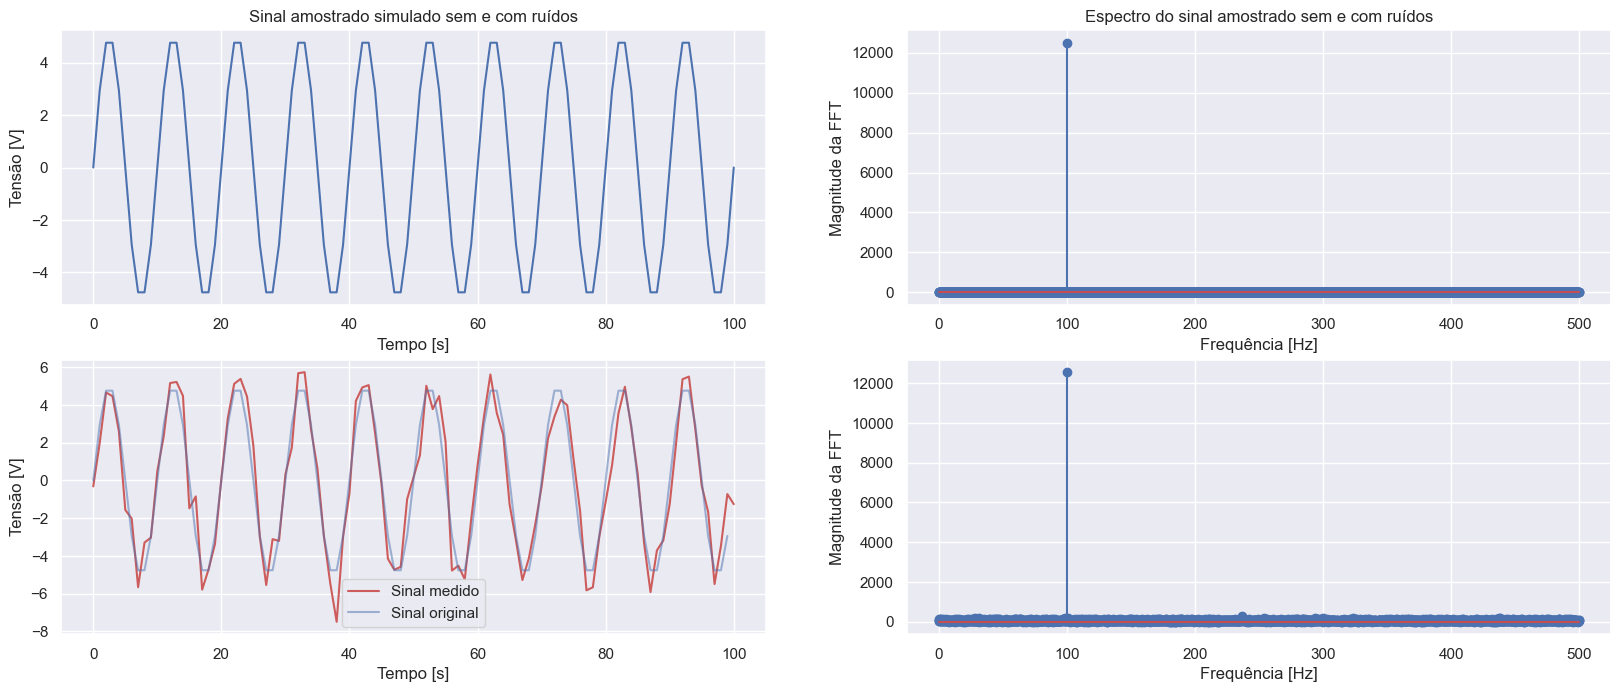

In [5]:
# Mostrando primeiros 20 segundos:

# Senoide 
plt.subplot(221);
sns.lineplot(y = sinal[0:round(20*N/(fs))+1], x = t[0:round(20*N/(fs))+1]);
# (2 ciclos = 20 seg => 10 seg / ciclo => fl = 1/10 = 0.1 Hz, frequencia normalizada f/fs, correta!)
plt.ylabel('Tensão [V]');
plt.xlabel('Tempo [s]');
plt.title('Sinal amostrado simulado sem e com ruídos');

# FFT sinal
plt.subplot(222);
S = np.abs(fft(sinal))
F = fftfreq(len(S), d=1/fs)
plt.stem(F[0:round(len(F)/2)],S[0:round(len(S)/2)])
# plt.stem(F[0:300],S[0:300])
plt.ylabel('Magnitude da FFT');
plt.xlabel('Frequência [Hz]');
plt.title('Espectro do sinal amostrado sem e com ruídos');

# Senoide + ruido
plt.subplot(223);
# Gerando ruído gaussiano de média zero, e amplitude 2.5 (SNR = 10/2.5 = 4)
ruido1 = rd.randn(N,)
ruidoso = sinal + ruido1
sns.lineplot(y = ruidoso[0:round(20*N/(fs))+1], x = t[0:round(20*N/(fs))+1], color = 'indianred');
sns.lineplot(y = sinal[0:round(20*N/(fs))], x = t[0:round(20*N/(fs))], alpha=0.5);
plt.legend(['Sinal medido', 'Sinal original']);
plt.ylabel('Tensão [V]');
plt.xlabel('Tempo [s]');


# FFT sinal ruidoso
plt.subplot(224);
R = np.abs(fft(ruidoso))
Fr = fftfreq(len(R), d=1/fs)
plt.stem(Fr[0:round(len(Fr)/2)],R[0:round(len(R)/2)]);
# plt.stem(F[0:300],S[0:300])
plt.ylabel('Magnitude da FFT');
plt.xlabel('Frequência [Hz]');


def niasFFT(sinal, fs):
    S = fft(sinal)
    SINALf = np.abs(S)
    SINALa = np.angle(S)
    FREQs = fftfreq(len(SINALf), d=1/fs)
    return [FREQs,SINALf, SINALa]

# Bin com pico de frequência: 
bin = np.where(S == max(S))
print('Bin',bin[0][0])
print('Frequência:',F[bin[0][0]], '=',f0,'(f0 do sinal original)')
print('Logo, para selecionar o valor da fft na f0, por exemplo:')
print('S[np.where(F==f0)[0][0]] =>',S[np.where(F==f0)[0][0]], '=', 'S[bin] = S[500] = ', S[500])
# Selecionar amostras de zero até TEMPO_DESEJADO (sem segundos) para plotar tempo contínuo referente:
# [0: round(TEMPO_DESEJADO*N/(fs))+1 ]

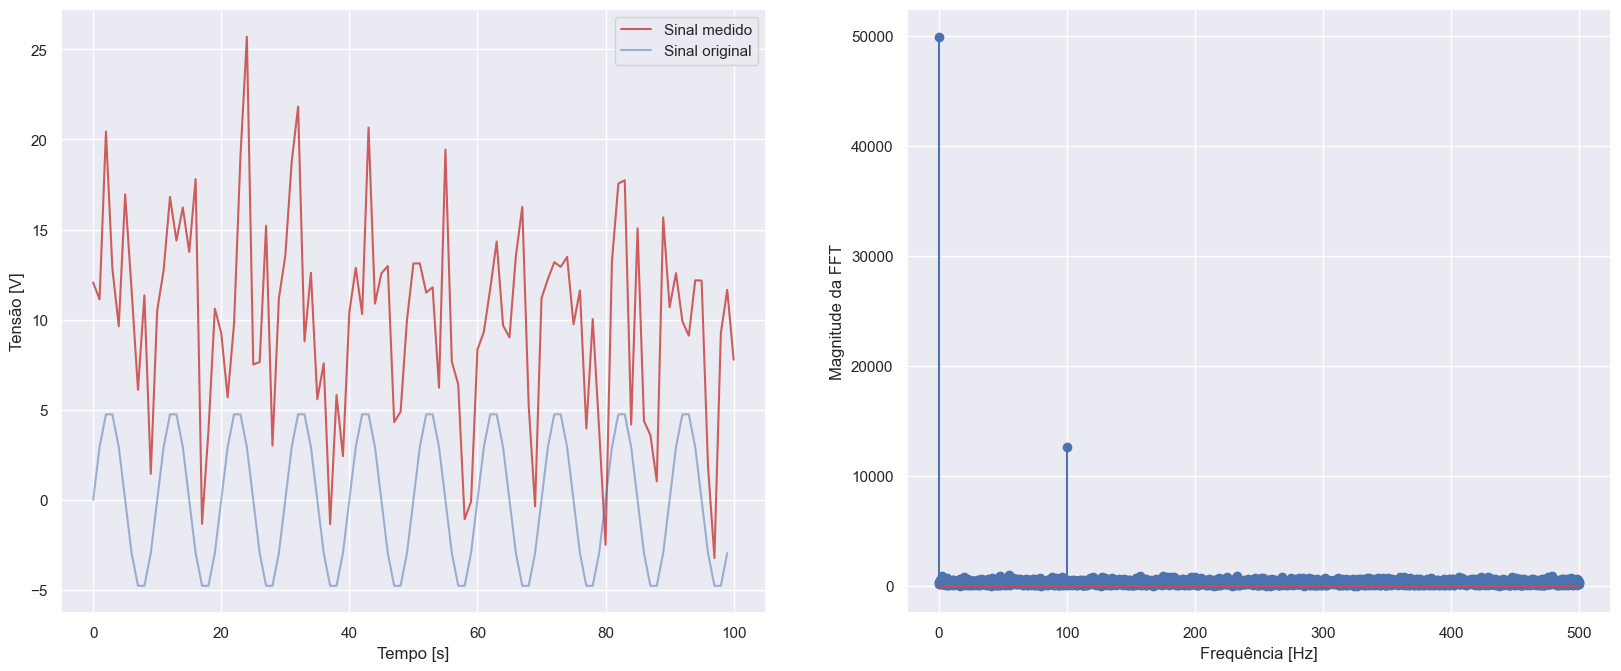

In [6]:
# Senoide + ruido
plt.subplot(121);
# Gerando ruído gaussiano de média zero, e amplitude 2.5 (SNR = 10/2.5 = 4)
ruido2 = 5*rd.randn(N,) +10
ruidoso = sinal + ruido2
sns.lineplot(y = ruidoso[0:round(20*N/(fs))+1], x = t[0:round(20*N/(fs))+1], color = 'indianred');
sns.lineplot(y = sinal[0:round(20*N/(fs))], x = t[0:round(20*N/(fs))], alpha=0.5);
plt.legend(['Sinal medido', 'Sinal original']);
plt.ylabel('Tensão [V]');
plt.xlabel('Tempo [s]');


# FFT sinal ruidoso
plt.subplot(122);
R = np.abs(fft(ruidoso))
Fr = fftfreq(len(R), d=1/fs)
plt.stem(Fr[0:round(len(Fr)/2)],R[0:round(len(R)/2)]);
# plt.stem(F[0:300],S[0:300])
plt.ylabel('Magnitude da FFT');
plt.xlabel('Frequência [Hz]');


def niasFFT(sinal, fs):
    S = fft(sinal)
    SINALf = np.abs(S)
    SINALa = np.angle(S)
    FREQs = fftfreq(len(SINALf), d=1/fs)
    return [FREQs,SINALf, SINALa]

In [7]:
# Validação de uso das funções:
[Freq, Si, _] = niasFFT(sinal = sinal, fs=fs)
print(sum(S-Si))
bin_f0 = np.where(Freq==f0)
print(bin_f0)
print(Si[bin_f0[0][0]])
print(F[np.where(Si == max(S))[0][0]])

0.0
(array([500], dtype=int64),)
12500.0
100.0


# 2 - Definições

## 2.1 - SFT: Spectral F-Test

### 2.1.1 - Definição e Funções

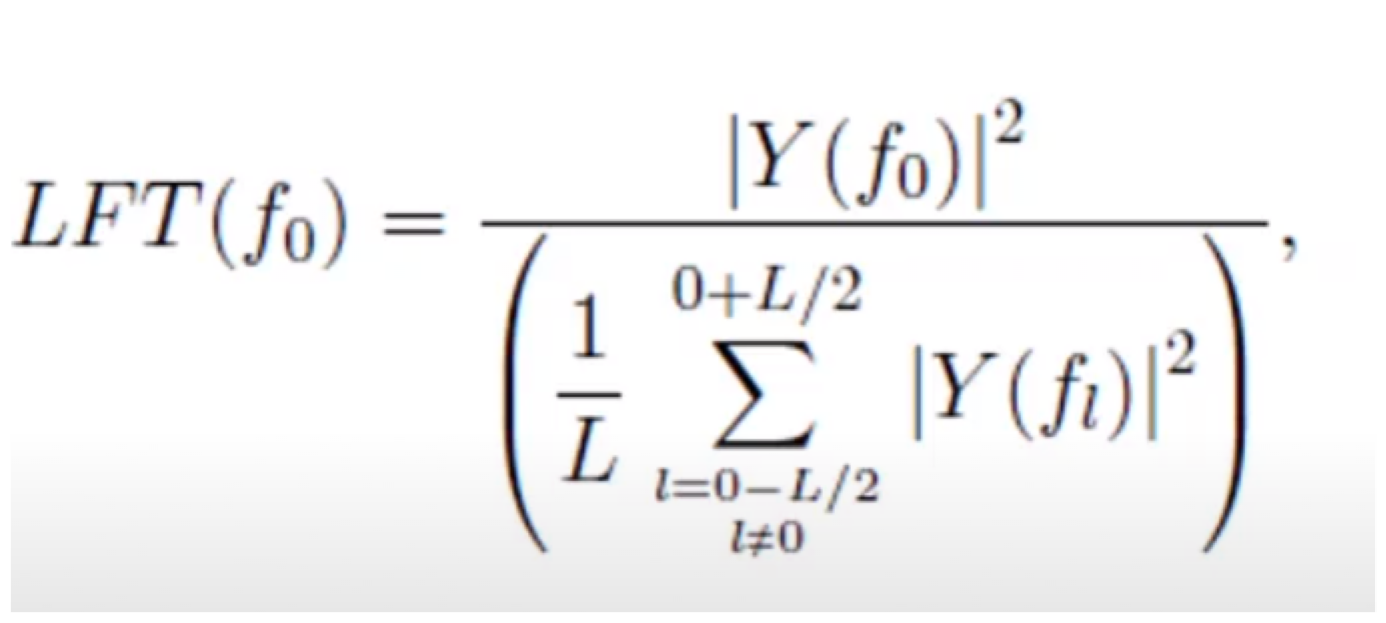

In [8]:
# Equação:
# <img src = "../res/sft.png"/>
plt.imshow(mpimg.imread('../res/sft.png')); plt.grid(False); plt.xticks([]); plt.yticks([]);

In [9]:
def vc_SFT(L, alpha = 0.05, VERBOSE = 0):
    # valor crítico teórico, dado tomando inversa da distribuição acumulada F
    # (Fisher-Snedecor)
    # com significancia 1-alpha (95% se não for alterada)
    vc = FDIST.ppf(1-alpha, 2,2*L) 
    
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico SFT: ',vc)

    return vc
        #fce999 TODO: perguntar por que 2 e 2*L!

def ord_SFT(sinal, L, BIN):
    # L: tamanho das laterais
    SINAL = np.abs(fft(sinal))

    central = round(BIN) # certifica inteiro (não float)
    lateralMenor = round(central-L/2)
    lateralMaior = round(central+L/2)+1       

    DEN =(SINAL[central])**2
    SINAL_lateral = np.array(list(SINAL[lateralMenor:central])+list(SINAL[central+1:lateralMaior])) 
    NUM = (1/L)*np.sum((SINAL_lateral)**2)
    SFT = DEN/NUM
    
    return [SINAL,SFT]

## 2.2 - CSM: Component Synchrony Measure 

### 2.2.1 - Definição e Funções: 

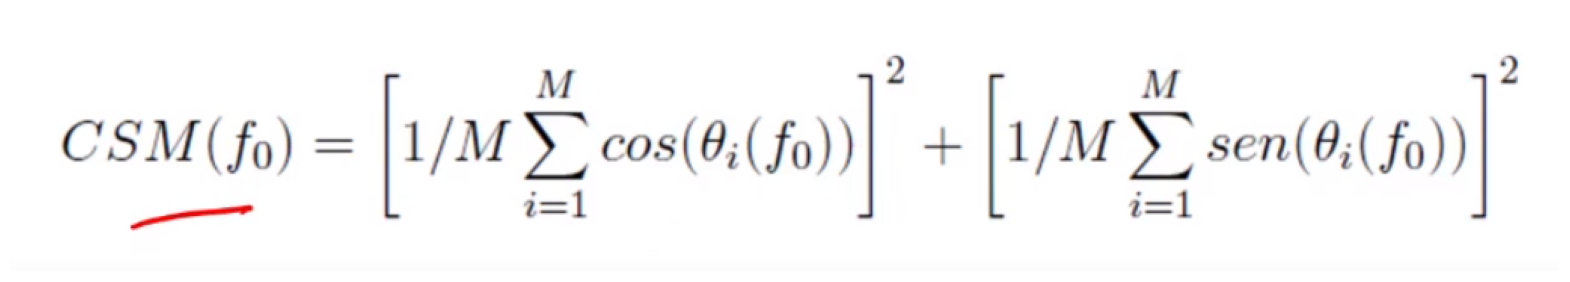

In [10]:
# Equação:
# <img src = "../res/csm.png"/>
plt.imshow(mpimg.imread('../res/csm.png')); plt.grid(False); plt.xticks([]); plt.yticks([]);

In [11]:
def vc_CSM(M, alpha = 0.05, VERBOSE=0):
    vc = chi2.ppf(1-alpha,2)/(2*M)
    
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico CSM: ',vc)

    return vc


def ord_CSM(sinal, tamanhoJanela, M):
    if len(sinal)-tamanhoJanela*M>=0:
        sinal = np.reshape(sinal[0:tamanhoJanela*M], (M,tamanhoJanela))

        FFT_SINAL = fft(sinal).transpose()
        angulo = np.angle(FFT_SINAL)

        s = ((1/M)*(np.sum(np.sin(angulo),1)))**2
        c = ((1/M)*(np.sum(np.cos(angulo),1)))**2

        CSM =  c+s

        return [FFT_SINAL,CSM]
    else:
        print('Erro no número de janelas', round(tamanhoJanela),'(ou amostras, M =', M,'\b) escolhido.')
        print('Tamanho do Sinal menos M*tamanhoJanela:', len(sinal)-M*tamanhoJanela)
        print('(Retorna 0)')
        return 0 

## 2.3 - MSC: Magnitude-Squared Coherence

### 2.3.1 - Definição e Funções

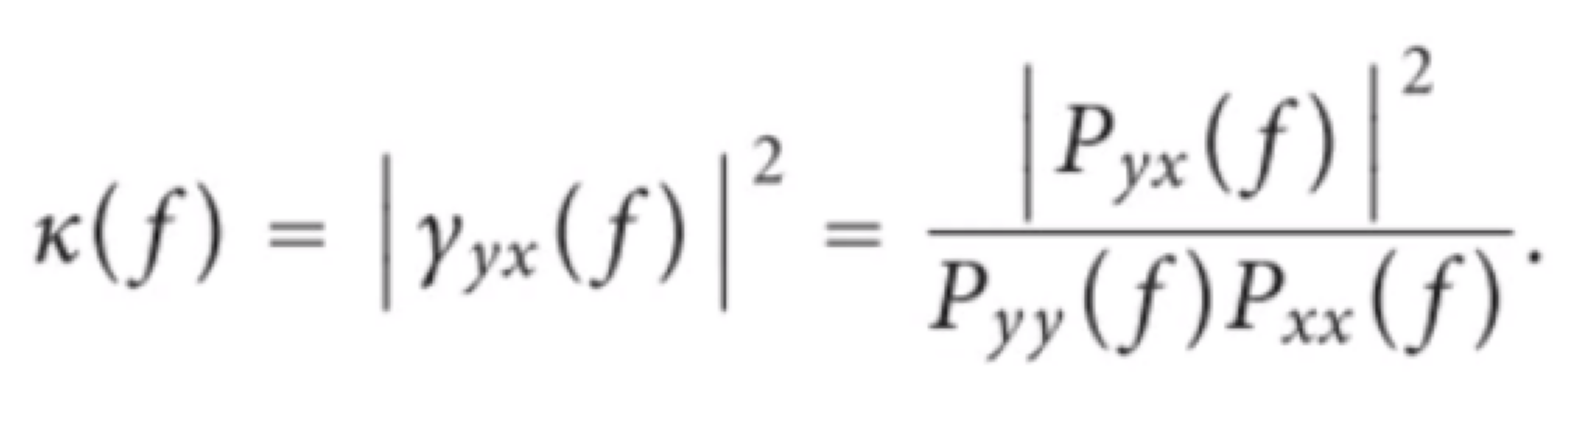

In [12]:
# Equação:
# <img src = "../res/msc.png"/>
plt.imshow(mpimg.imread('../res/msc.png')); plt.grid(False); plt.xticks([]); plt.yticks([]);

In [13]:
def vc_MSC(M, alpha = 0.05, VERBOSE = 0):
    vc = 1-alpha**(1/(M-1))
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico MSC: ',vc)
    return vc # valor crítico

def ord_MSC(sinal, tamanhoJanela, M):
    sinal = np.reshape(sinal[0:tamanhoJanela*M], (M,tamanhoJanela))

    SINAL = fft(sinal).transpose()
    
    MSC = (np.abs(np.sum(SINAL,axis=1))**2) / (M*np.sum(np.abs(SINAL)**2,axis=1))

    return [SINAL,MSC]

## 2.4 - Controle de significância (MSC)

### 2.4.1 - Definindo:

In [14]:
# Usando sequencial generalizado, queremos FP= 5% no teste GERAL! Qual deve ser FPi (cada iteração)?

def corrige_alfaMSC(
    tj = 100, # cada janela um segundo 
    Mmin = 10,
    Mstep = 10,
    Mmax = 60,
    BIN = 7,
    alphaD = 5/100,  #fff significancia a atingir
    alphaInicial = -1,
    tx_apr = 0.02,    # taxa de aprendizado
    nSim = 1e3, 
    itMAX = 300,
    VERBOSE = 1):

    print('\nCalculando alpha corrigido para alphaD =', alphaD)

    N = round(Mmax*tj)  # tamanho máximo do sinal
    nSim = round(nSim)  # numero de simulações
    if alphaInicial<0: alphas = [alphaD/(Mmax/Mstep)] # primeiro "chute" = alpha Desejado
    else: alphas = [alphaInicial]
    alphaR = 1   # significancia REAL
    it = 1  # iteração atual

    while alphaR > alphaD and it <= itMAX:
        if it>1:
            # Se J = mse = e^2 (univariado), então:
            grad = 2*alphaR - alphaD
            alphas.append(alphas[-1] -tx_apr*(grad))

        descricao = 'Iteração #'+str(it); it+=1; nd = 0; 
        
        if VERBOSE>=2:
            for _ in tqdm(range(1,nSim+1), leave=(VERBOSE>1), desc=descricao):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        if VERBOSE==1:
            for _ in tqdm(range(1,nSim+1), leave=False):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        else:
            for _ in range(1,nSim+1):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        alphaR = nd/(nSim*(Mmax/Mstep))


        if VERBOSE==3:
            print('Significancia atingida:',round(alphaR*100,ndigits=3),'\b%')
            print('Alpha corrigido:', round(alphas[-1],ndigits=3))

    if VERBOSE==1:
        print('Significancia atingida:',round(alphaR*100,ndigits=3),'\b%')
        print('Alpha corrigido:', round(alphas[-1],ndigits=4))
    
    if it>=itMAX: 
        print('Iteração máxima (',itMAX,') atingida!')
        print('Significancia alcançada:',round(alphaR*100,ndigits=3),'\b%')
        print('Retornando último valor de alpha corrigido: ', round(alphas[-1],ndigits=4))
    
    return alphas[-1]

# Exemplo:
print(corrige_alfaMSC(alphaD=0.04,VERBOSE=3))


Calculando alpha corrigido para alphaD = 0.04


Iteração #1: 100%|██████████| 1000/1000 [00:00<00:00, 1166.92it/s]


Significancia atingida: 1.167%
Alpha corrigido: 0.007
0.006666666666666667


# 3 - Validando meus resultados: 

## 3.1 - Validação teste da média:

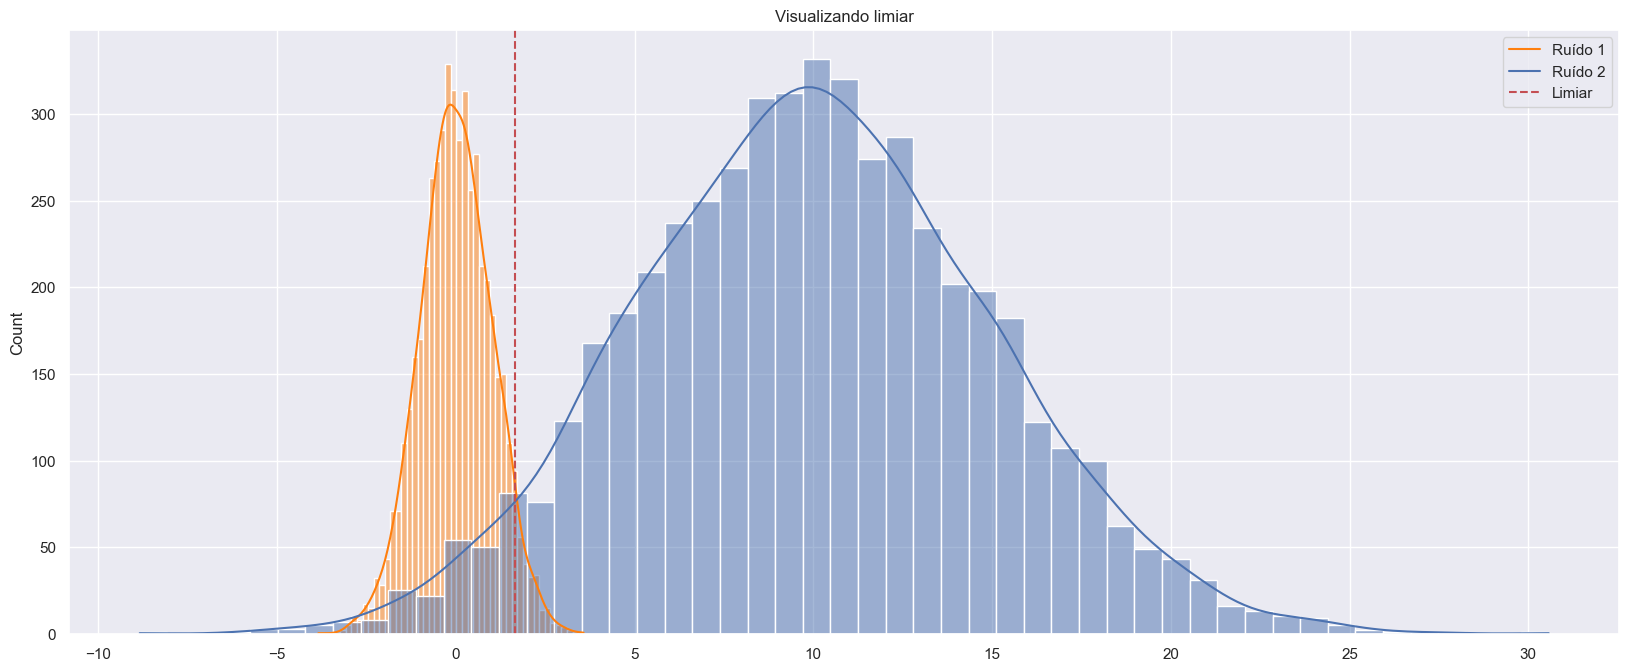

In [15]:
fig,ax = plt.subplots();
limiar = vc_pratico(ruido1,alpha=0.05);
sns.histplot(x= ruido1, kde= True,ax=fig.axes[0],color='tab:orange')  ;
sns.histplot(x= ruido2, kde= True,ax=fig.axes[0]);
plt.axvline(limiar, 0,1,c='r',linestyle='--');
fig.axes[0].set_title('Visualizando limiar');
plt.legend(['Ruído 1','Ruído 2','Limiar']);

## 3.2 - Validação SFT:

### 3.2.0 - Validação do espectro da ORD:

100
(Detecções no ruído 1) FP: 0.0
(Detecções no ruído 2) FP: 0.0
Detectou a senóide pura? Sim.
Detectou a senóide + ruído 1? Sim.
Detectou a senóide + ruído 2? Sim.


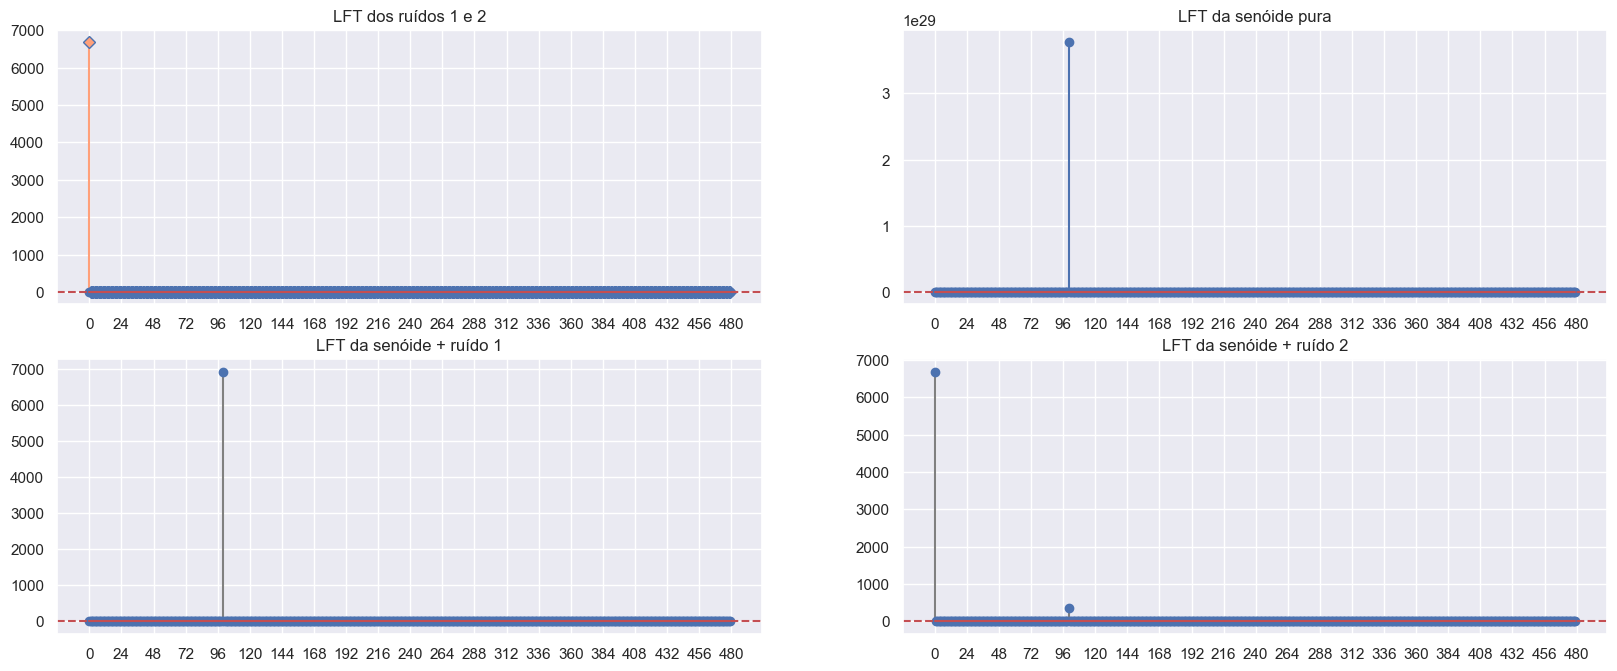

In [28]:
# Calcula senóide base e frequência para encontrar bins:
f0 = 100
fs = 1000
N = round(1e3)
L = 20

ruido1 = rd.randn(N)
ruido2 = 5*rd.randn(N) + 10
sinal = senoide(amplitude=5, N=N, f0 = f0, fs=fs)
[F, _, _] = niasFFT(sinal = sinal, fs=fs)
bin_f0 = np.where(F==f0)[0][0]
print(bin_f0)
limiar = vc_SFT(L=L, alpha=0.05)

# Calcula CSM:
o1 = np.zeros((round(N/2 - L)))
o2 = np.zeros((round(N/2 - L)))
o3 = np.zeros((round(N/2 - L)))
o4 = np.zeros((round(N/2 - L)))
o5 = np.zeros((round(N/2 - L)))

for ff in range(0,round(N/2)-L):
    [_,o1[ff]] = ord_SFT(sinal=ruido1, L=L, BIN=ff)
    [_,o2[ff]] = ord_SFT(sinal=ruido2, L=L, BIN=ff)
    [_,o3[ff]] = ord_SFT(sinal=sinal, L=L, BIN=ff)
    [_,o4[ff]] = ord_SFT(sinal=sinal+ruido1, L=L, BIN=ff)
    [_,o5[ff]] = ord_SFT(sinal=sinal+ruido2, L=L, BIN=ff)

plt.subplot(221);
markerline, stemlines, baseline  = plt.stem(o2,linefmt='lightsalmon', markerfmt='D');
markerline.set_markerfacecolor('lightsalmon');
plt.stem(o1,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o2)+len(o2)/20,len(o2)/20));
plt.title('LFT dos ruídos 1 e 2');

plt.subplot(222);
plt.stem(o3);
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o3)+len(o3)/20,len(o3)/20));
plt.title('LFT da senóide pura');

plt.subplot(223);
plt.stem(o4,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o4)+len(o4)/20,len(o5)/20));
plt.title('LFT da senóide + ruído 1');

plt.subplot(224);
plt.stem(o5,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o5)+len(o5)/20,len(o5)/20));
plt.title('LFT da senóide + ruído 2');

print('(Detecções no ruído 1) FP:',np.sum(np.where(o1[bin_f0]>limiar))/N)
print('(Detecções no ruído 2) FP:',np.sum(np.where(o2[bin_f0]>limiar))/N)
print('Detectou a senóide pura?', np.where(o3[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 1?', np.where(o4[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 2?', np.where(o5[bin_f0]>limiar,'Sim.','Não.'))

### 3.2.1 - Validação do valor crítico:

Simulando: 100%|██████████| 25/25 [00:02<00:00, 11.21it/s]


Pronto


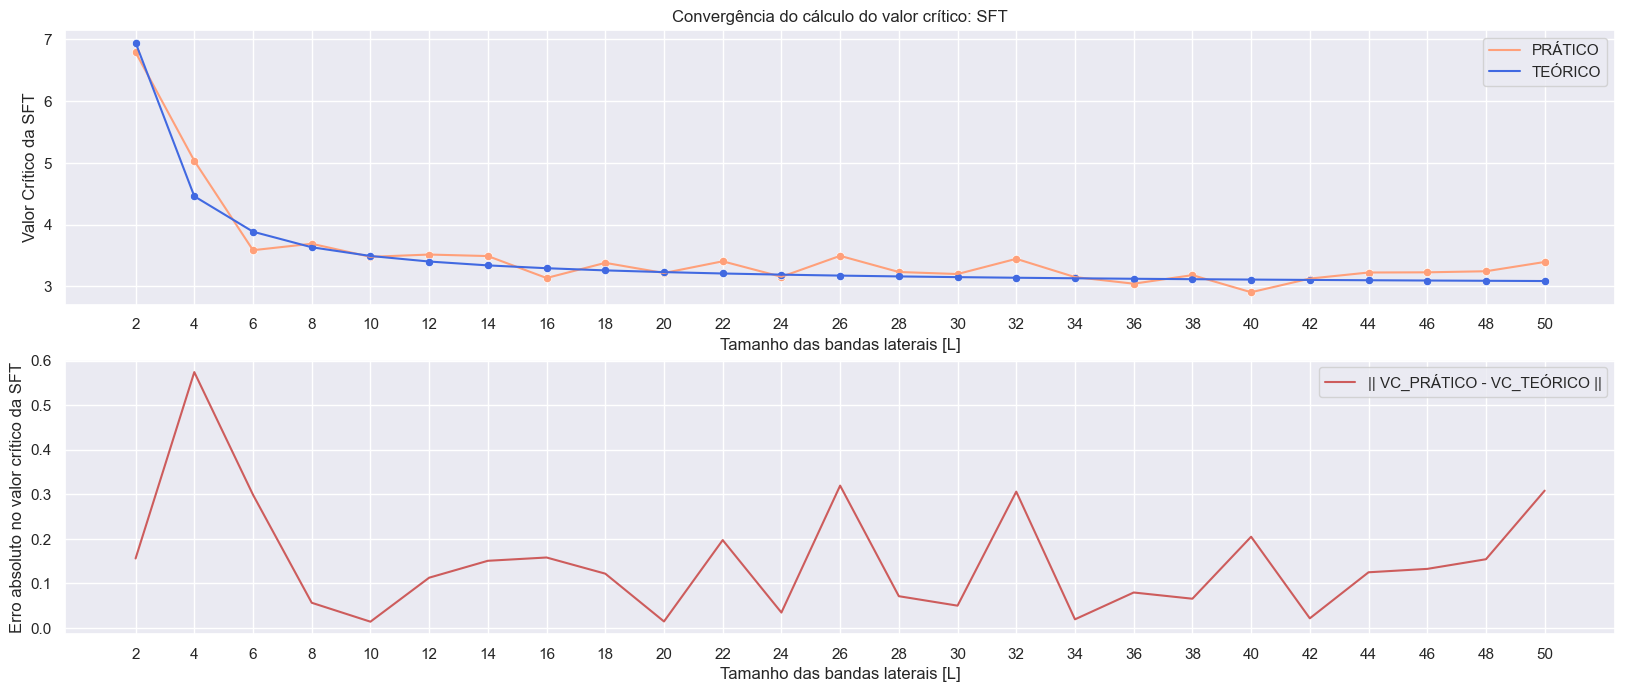

In [17]:
# MC:
nSim = round(1e3) # numero de simulações
N = round(1e3)  # "duração" do sinal
bin_f0 = 50
# 101 # um bin qualquer, já que é ruído
Ls = np.arange(2,52,2)   # tamanho qualquer 
x = np.zeros((N,))
vcp = np.zeros((len(Ls)))
vct = np.zeros((len(Ls)))
oo = np.zeros((nSim,))
mediaRuido = 0 # média do ruído
energia_ruido = 1 # desvio padrão

for ll in tqdm(range(0,len(Ls)), desc='Simulando'):
    for ii in range(0,nSim):
        x = energia_ruido*rd.randn(N,) + mediaRuido
        [X,ORD] = ord_SFT(sinal=x, L=Ls[ll], BIN= bin_f0)
        oo[ii] = ORD

    vct[ll] = vc_SFT(Ls[ll])
    
    vcp[ll] = vc_pratico(oo) # alpha definido a 5%

print('Pronto')

plt.subplot(211)
p = sns.lineplot(x = Ls,y = vcp, color = 'lightsalmon') 
p = sns.lineplot(x = Ls,y = vct, color = 'royalblue') 
plt.xticks(np.arange(Ls[0],Ls[-1]+2,2));
plt.title('Convergência do cálculo do valor crítico: SFT');
plt.ylabel('Valor Crítico da SFT');
plt.xlabel('Tamanho das bandas laterais [L]');

sns.scatterplot(x = Ls,y = vcp, color = 'lightsalmon'); 
sns.scatterplot(x = Ls,y = vct, color = 'royalblue'); 
plt.legend(['PRÁTICO','TEÓRICO']);

plt.subplot(212)
p2 = sns.lineplot(x = Ls,y= abs(vcp-vct), color = 'indianred') 
plt.ylabel('Erro absoluto no valor crítico da SFT');
plt.legend(['|| VC_PRÁTICO - VC_TEÓRICO ||']);
plt.xlabel('Tamanho das bandas laterais [L]');
plt.xticks(np.arange(Ls[0],Ls[-1]+2,2));

### 3.2.2 - Validação SFT: Single-shot MC

Simulando: 100%|██████████| 10000/10000 [00:01<00:00, 8392.36it/s]


Probabilidade de detecção atingida: 93.89%
(PD esperada =  95.0%)
Detectou?  True


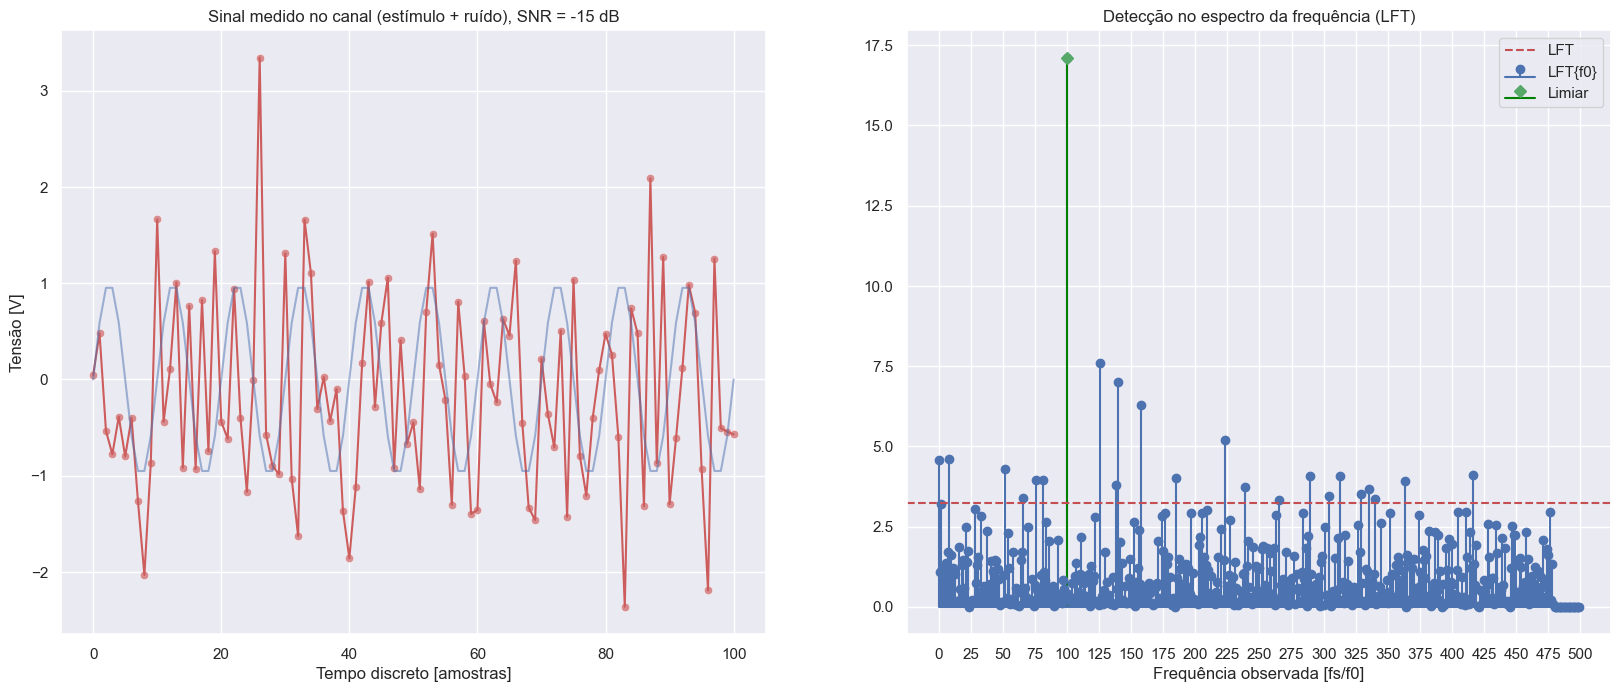

In [18]:
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)
N = int(1e3) # num. de pontos na senóide

# Calcula senóide base e frequência para encontrar bins:
f0 = 100
fs = 1000
x = senoide(amplitude=1, N=N, f0 = f0, fs=fs)
# Ls = np.arange(2,52,2)
L = 20
bin_f0 = round(len(x)*f0/fs)
# [F, _, _] = niasFFT(sinal = x, fs=fs)
# bin_f0 = np.where(F==f0)[0][0]

mediaRuido = 0
energia_ruido = 1
SNRi = -15

limiar = vc_SFT(L=L) # alpha = 5% (default)
nd = 0
hist = np.zeros((nSim,len(Ls)))
ORD = np.zeros((round(N/2),))


for i in tqdm(range(0,nSim), desc = 'Simulando'):
    # Soma ruido aleatório novo à senóide inicial, em cada simulação:
    ruido = mediaRuido + energia_ruido*rd.randn(N,)
    A = 10**(SNRi/20)*(energia_ruido**2);
    sinal = A*x + ruido
    
    if i == nSim-1:
        for ff in range(0,round(N/2)-L):
            [_, ORD[ff]]= ord_SFT(sinal=sinal, L=L, BIN=ff)

    [_, o]= ord_SFT(sinal=sinal, L=L, BIN=bin_f0)
    # Detecção?
    if o > limiar: nd +=1

alpha = 0.05
print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')
print('(PD esperada = ',100*(1-alpha),'\b%)')

fig = plt.subplot(121);
sns.scatterplot(data = sinal[0:101], color='indianred', alpha = 0.65);
sns.lineplot(data = sinal[0:101], color='indianred');
sns.lineplot(data = x[0:101], color='b', alpha = 0.5);
titulo = 'Sinal medido no canal (estímulo + ruído), SNR = '+str(SNRi)+' dB'
plt.title(titulo);
plt.xlabel('Tempo discreto [amostras]');
plt.ylabel('Tensão [V]');

plt.subplot(122);
# print(fs/f0) # ORD está na frequencia observada (fl = fs/f0)
# LFT(f):
plt.stem(ORD, linefmt= 'b', basefmt= 'b');
plt.stem(bin_f0, ORD[bin_f0], markerfmt='gD' ,linefmt= 'green',basefmt= 'green')

# LIMIAR:
plt.axhline(y=limiar, color='r', linestyle = '--');

# Estilo:
plt.title('Detecção no espectro da frequência (LFT)');
plt.xlabel('Frequência observada [fs/f0]');
plt.xticks(np.arange(0,round(len(ORD)+len(ORD)/20), len(ORD)/20))
plt.legend(['LFT','LFT{f0}','Limiar'])

print('Detectou? ', ORD[bin_f0] > limiar)
# Altere a amplitude do ruido para observar o efeito :)


### 3.2.3 - Validação SFT: Curva PD(SNR)

Simulando: 100%|██████████| 25/25 [02:06<00:00,  5.07s/it]


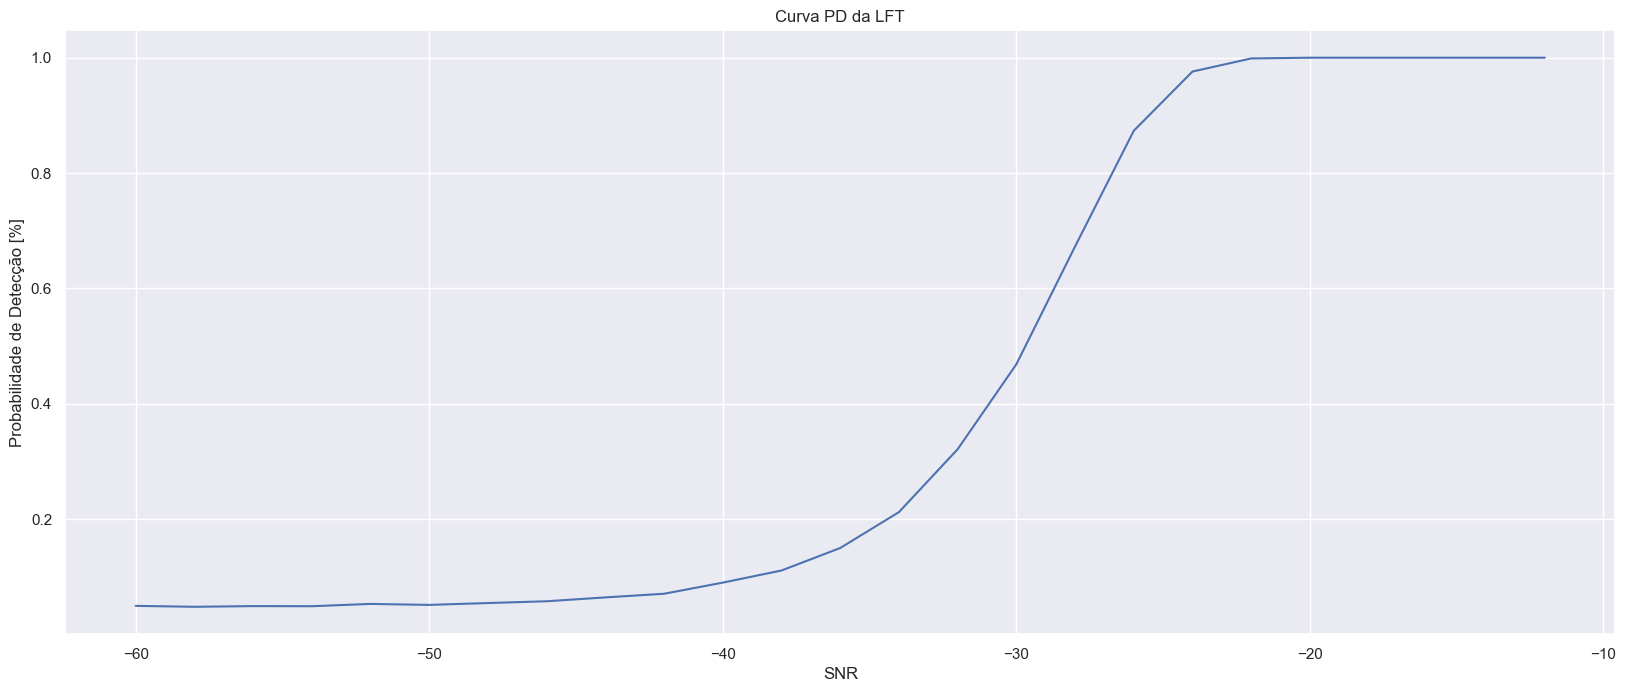

In [19]:
# Cerca de 2min30s emde simulação (24GB RAM, i5 8gen)
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)
N = int(1e4) # num. de pontos na senóide

# Calcula senóide base e frequência para encontrar bins:
f0 = 100; 
fs = 1000; 
L = 20; 
x = senoide(amplitude=1, N=N, f0 = f0, fs=fs)
bin_f0 = round(len(x)*f0/fs)
energia_ruido = 1 
amplitudeRuido = 0
limiar = vc_SFT(L=L) # alpha = 5%
listaSNRs = np.arange(-60,-10,2)
probDetecSFT = np.zeros((len(listaSNRs),1))

for i in tqdm(range(0,len(listaSNRs)), desc = 'Simulando'):
    SNRi = listaSNRs[i]; nd = 0;
    # A = amp/(10**(SNRi/-20))
    A = 10**(SNRi/20)*(energia_ruido**2);
    
    for _ in range(0,nSim):
        # Soma ruido aleatório novo à senóide inicial, em cada simulação:
        ruido = energia_ruido*rd.randn(N,)
        sinal = A*x + ruido

        # Calcula SFT na f0:
        [_, ORD]= ord_SFT(sinal=sinal, L=L, BIN=bin_f0)

        # Detecção?
        if ORD > limiar: nd +=1

    probDetecSFT[i] = nd/nSim
    # print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')


pDSFT = pd.DataFrame({'SNR': listaSNRs,'Probabilidade de Detecção [%]':probDetecSFT[:,0]})
sns.lineplot(data = pDSFT,x='SNR',y='Probabilidade de Detecção [%]');
plt.title('Curva PD da LFT');
pDSFT.to_csv('PD_SFT.csv')

## 3.3 Validação CSM:

### 3.3.0 - Validação do espectro da ORD:

(Detecções no ruído 1) FP: 3.1
(Detecções no ruído 2) FP: 2.7
Detectou a senóide pura? Sim.
Detectou a senóide + ruído 1? Sim.
Detectou a senóide + ruído 2? Sim.


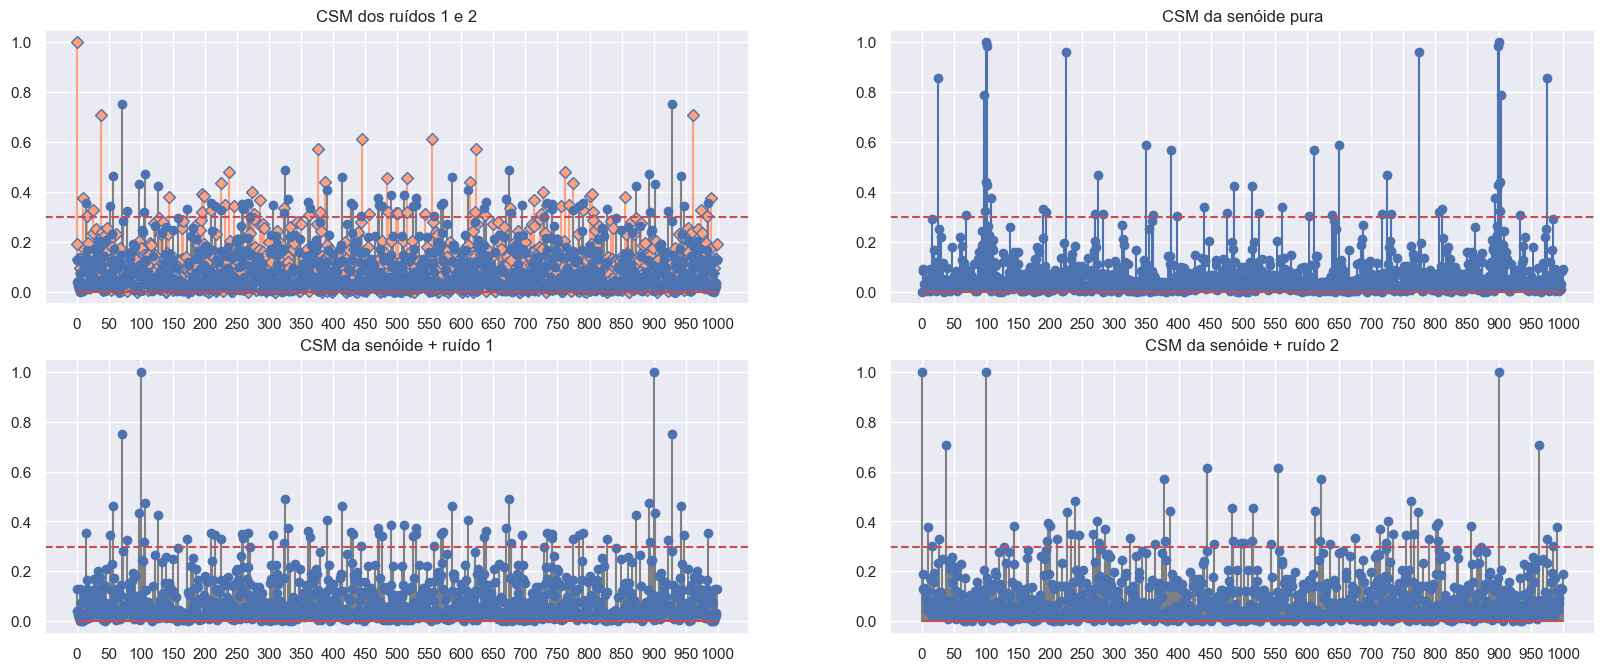

In [20]:
# Calcula senóide base e frequência para encontrar bins:
f0 = 100
fs = 1000
M = 10
tj = fs
N = M*tj

ruido1 = rd.randn(N)
ruido2 = 5*rd.randn(N)+10
sinal = senoide(amplitude=5, N=N, f0 = f0, fs=fs)
[F, _, _] = niasFFT(sinal = sinal, fs=fs)
bin_f0 = np.where(F==f0)[0][0]
limiar = vc_CSM(M=M, alpha=0.05)

# Calcula CSM:
[_,o1] = ord_CSM(sinal=ruido1, tamanhoJanela=tj, M=M)
[_,o2] =ord_CSM(sinal=ruido2, tamanhoJanela=tj, M=M)
[_,o3] =ord_CSM(sinal=sinal, tamanhoJanela=tj, M=M)
[_,o4] =ord_CSM(sinal=sinal+ruido1, tamanhoJanela=tj, M=M)
[_,o5] =ord_CSM(sinal=sinal+ruido2, tamanhoJanela=tj, M=M)

plt.subplot(221);
markerline, stemlines, baseline  = plt.stem(o2,linefmt='lightsalmon', markerfmt='D');
markerline.set_markerfacecolor('lightsalmon');
plt.stem(o1,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o2)+len(o2)/20,len(o2)/20));
plt.title('CSM dos ruídos 1 e 2');

plt.subplot(222);
plt.stem(o3);
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o3)+len(o3)/20,len(o3)/20));
plt.title('CSM da senóide pura');

plt.subplot(223);
plt.stem(o4,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o4)+len(o4)/20,len(o5)/20));
plt.title('CSM da senóide + ruído 1');

plt.subplot(224);
plt.stem(o5,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o5)+len(o5)/20,len(o5)/20));
plt.title('CSM da senóide + ruído 2');

tamanhoSinal = len(o3)
bin_f0 = round(f0*tamanhoSinal/fs)
print('(Detecções no ruído 1) FP:',np.sum(np.where(o1>limiar))/N)
print('(Detecções no ruído 2) FP:',np.sum(np.where(o2>limiar))/N)
print('Detectou a senóide pura?', np.where(o3[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 1?', np.where(o4[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 2?', np.where(o5[bin_f0]>limiar,'Sim.','Não.'))

### 3.3.1 - Validação do valor crítico:

Simulando: 100%|██████████| 12/12 [00:01<00:00,  6.12it/s]


Pronto


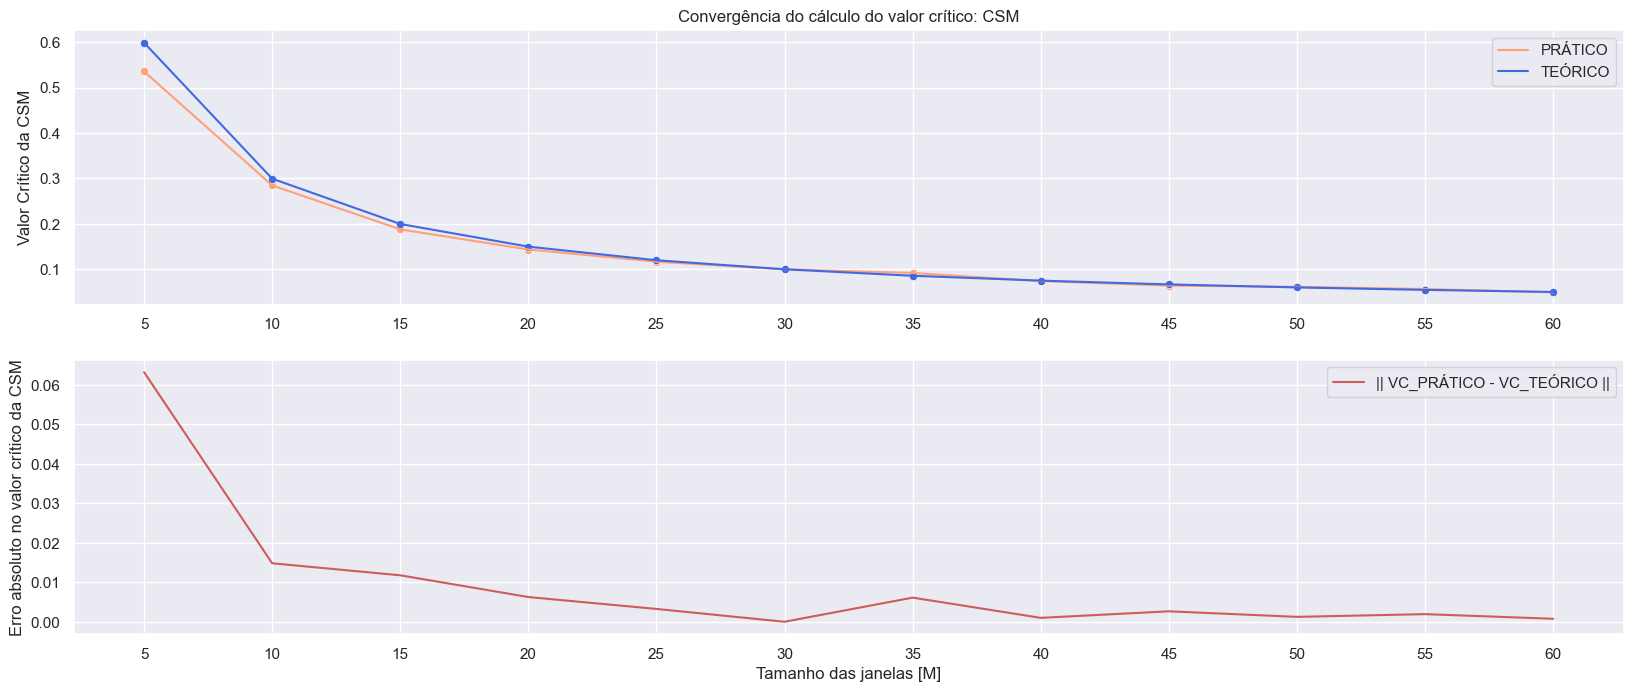

In [21]:
# MC:
## Parâmetros constantes:
nSim = round(1e3) # número de simulações
tj = 32     # tamanho da janela 
Mmin = 5; Mmax = 60; Mstep = 5; # Parâmetro livre da CSM
Ms = np.arange(Mmin,Mmax+Mstep,Mstep)   # tamanho qualquer 
bin = 7 # um bin qualquer
amplitudeRuido = 0 # média do ruído
energia_ruido = 1 # desvio padrão

## Variáveis:
vcp = np.zeros((len(Ms)))
vct = np.zeros((len(Ms)))
oo = np.zeros((nSim,tj))

## Simulação:
for mm in tqdm(range(0,len(Ms)), desc='Simulando'):
    for ii in range(0,nSim):
        N = Ms[mm]*tj  # "duração" do sinal
        x = amplitudeRuido + energia_ruido*rd.randn(N,)
        [_,ORD] = ord_CSM(sinal=x, tamanhoJanela=tj, M=Ms[mm])
        bin_f0 = round(len(ORD)*f0/fs)
        oo[ii] = ORD[bin_f0]

    vct[mm] = vc_CSM(Ms[mm])
    vcp[mm] = vc_pratico(oo) # alpha definido a 5%

print('Pronto')

plt.subplot(211);
p = sns.lineplot(x = Ms,y= vcp, color = 'lightsalmon');
p = sns.lineplot(x = Ms,y = vct, color = 'royalblue');

plt.title('Convergência do cálculo do valor crítico: CSM');
plt.ylabel('Valor Crítico da CSM');

sns.scatterplot(x = Ms,y= vcp, color = 'lightsalmon'); 
sns.scatterplot(x = Ms,y = vct, color = 'royalblue'); 
plt.legend(['PRÁTICO','TEÓRICO']);
plt.xticks(Ms);

plt.subplot(212);
p2 = sns.lineplot(x = Ms,y= abs(vcp-vct), color = 'indianred');
plt.ylabel('Erro absoluto no valor crítico da CSM');
plt.legend(['|| VC_PRÁTICO - VC_TEÓRICO ||']);
plt.xlabel('Tamanho das janelas [M]');
plt.xticks(Ms);

### 3.3.2 - Validação CSM: Single-shot MC

Simulando: 100%|██████████| 10000/10000 [00:14<00:00, 682.87it/s]


Probabilidade de detecção atingida: 94.26%
(PD esperada =  95.0%)
Detectou?  True


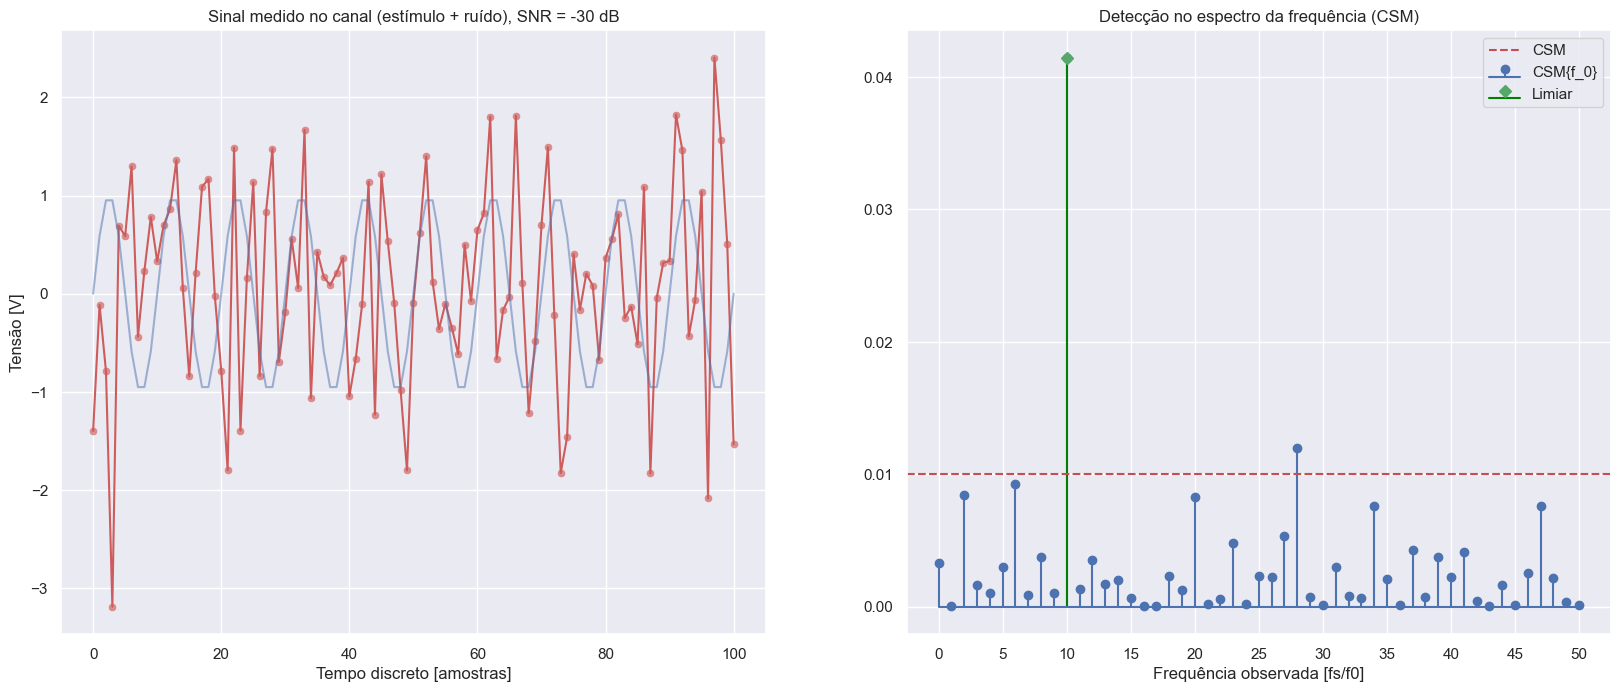

In [22]:
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)

# Calcula senóide base:
f0 = 100
fs = 1000
M = 300 # número de janelas até o teste
tj = 100 # 1 seg/jan
N = M*tj # num. de pontos na senóide
x = senoide(amplitude=1, N=N, f0 = f0, fs=fs)

amplitudeRuido = 0
energia_ruido = 1
SNRi = -30
A = 10**(SNRi/20)*(energia_ruido**2);
limiar = vc_CSM(M=M) # alpha = 5%
nd  = 0

for i in tqdm(range(0,nSim), desc = 'Simulando'):
    # Soma ruido aleatório novo à senóide inicial, em cada simulação:
    A = 10**(SNRi/20)*(energia_ruido**2);
    ruido =  amplitudeRuido+ energia_ruido*rd.randn(N,)
    sinal = A*x  + ruido
    
    # Calcula SFT na f0:
    [_, ORD]= ord_MSC(sinal = sinal, tamanhoJanela=tj, M= M)

    # Detecção?
    bin_f0 = round(len(ORD)*f0/fs)
    if  ORD[bin_f0] > limiar: nd +=1


print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')
print('(PD esperada = ',100*(1-alpha),'\b%)')

fig2 = plt.subplot(121);
sns.scatterplot(data = sinal[0:101], color='indianred', alpha = 0.65);
sns.lineplot(data = sinal[0:101], color='indianred');
sns.lineplot(data = x[0:101], color='b', alpha = 0.5);
titulo = 'Sinal medido no canal (estímulo + ruído), SNR = '+str(SNRi)+' dB'
plt.title(titulo);
plt.xlabel('Tempo discreto [amostras]');
plt.ylabel('Tensão [V]');

plt.subplot(122);
# print(fs/f0) # ORD está na frequencia observada (fl = fs/f0)
plt.stem(ORD[0:round(len(ORD)/2 +1)], linefmt= 'b', basefmt= 'b');
plt.stem(bin_f0, ORD[bin_f0], markerfmt='gD' ,linefmt= 'green',basefmt= 'green')
plt.axhline(y=limiar, color='r', linestyle = '--');
plt.title('Detecção no espectro da frequência (CSM)');
plt.xlabel('Frequência observada [fs/f0]');
plt.xticks(np.arange(0,round(len(ORD)/2 +len(ORD)/20), len(ORD)/20))
plt.legend(['CSM','CSM{f_0}','Limiar'])

# plt.legend('CSM','Limiar');

print('Detectou? ', ORD[bin_f0] > limiar)
# Altere a amplitude do ruido para observar o efeito :)

### 3.3.3 - Validação CSM: Curva PD(SNR)

Simulando: 100%|██████████| 25/25 [11:01<00:00, 26.45s/it]


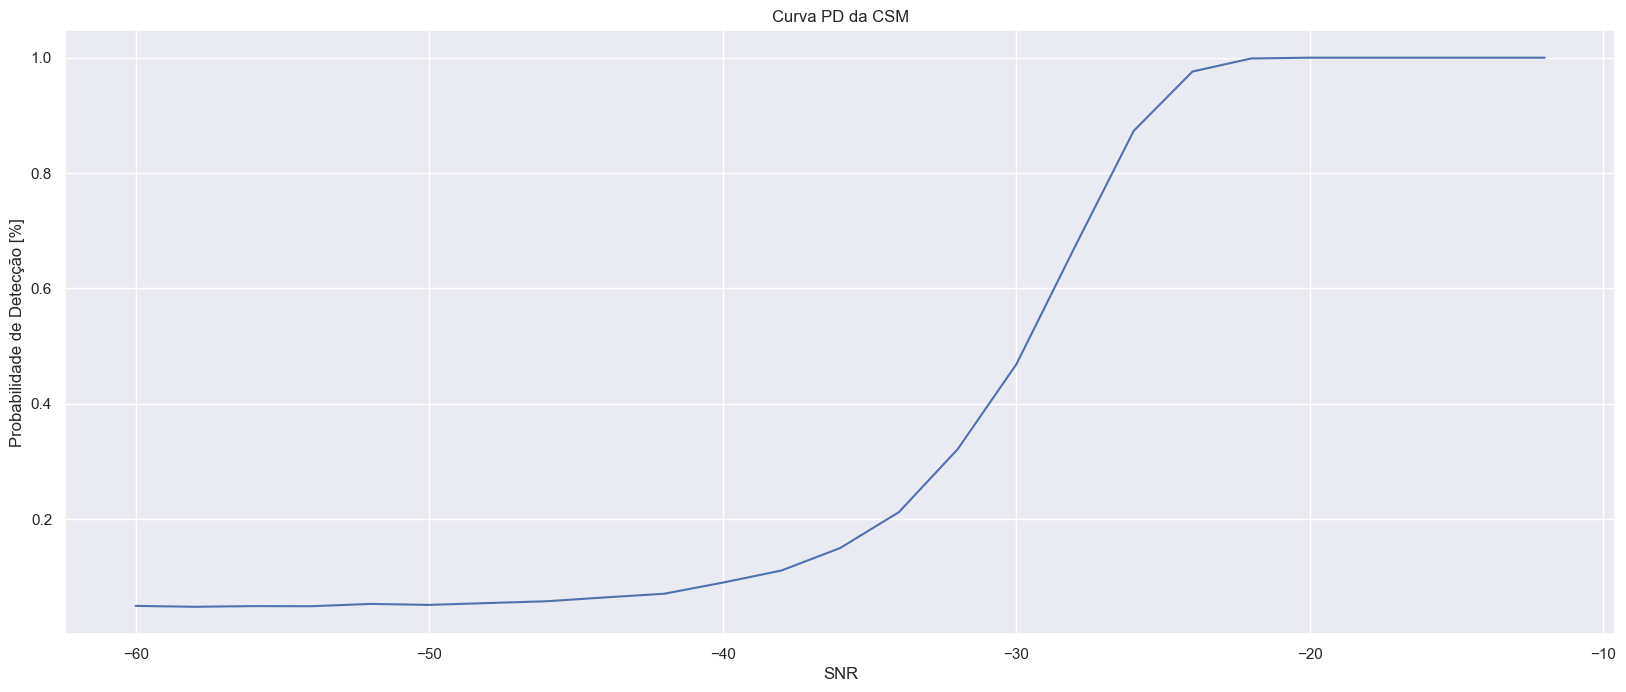

In [23]:
# Cerca de 15mins em média de simulação (24GB RAM, i5 8gen)
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)

# Calcula senóide base:
f0 = 100
fs = 1000
M = 300 # número de janelas até o teste
tj = 100 # 1 seg/jan
N = M*tj # num. de pontos na senóide
x = senoide(amplitude=1, N=N, f0 = f0, fs=fs)
limiar = vc_MSC(M=M) # alpha = 5%

amplitudeRuido = 0
energia_ruido = 1
listaSNRs = np.arange(-60,-10,2)
probDetecCSM = np.zeros((len(listaSNRs),1))
nd  = 0

for i in tqdm(range(0,len(listaSNRs)), desc = 'Simulando'):
    SNRi = listaSNRs[i]; nd = 0;
    A = 10**(SNRi/20)*(energia_ruido**2);
    
    for _ in range(0,nSim):
        # Soma ruido aleatório novo à senóide inicial, em cada simulação:
        ruido =  amplitudeRuido+ energia_ruido*rd.randn(N,)
        sinal = A*x  + ruido

        # Calcula SFT na f0:
        [_, ORD]= ord_CSM(sinal = sinal, tamanhoJanela=tj, M= M)

        # Detecção?
        bin_f0 = round(len(ORD)*f0/fs)
        if  ORD[bin_f0] > limiar: nd +=1

    probDetecCSM[i] = nd/nSim
    # print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')

pDCSM = pd.DataFrame({'SNR': listaSNRs,'Probabilidade de Detecção [%]':probDetecCSM[:,0]})
sns.lineplot(data = pDSFT,x='SNR',y='Probabilidade de Detecção [%]');
plt.title('Curva PD da CSM');
pDCSM.to_csv('PD_CSM.csv')

## 3.4 Validação MSC:

### 3.4.0 - Validação do espectro da ORD:

(Detecções no ruído 1) FP: 1.5
(Detecções no ruído 2) FP: 3.1
Detectou a senóide pura? Sim.
Detectou a senóide + ruído 1? Sim.
Detectou a senóide + ruído 2? Sim.


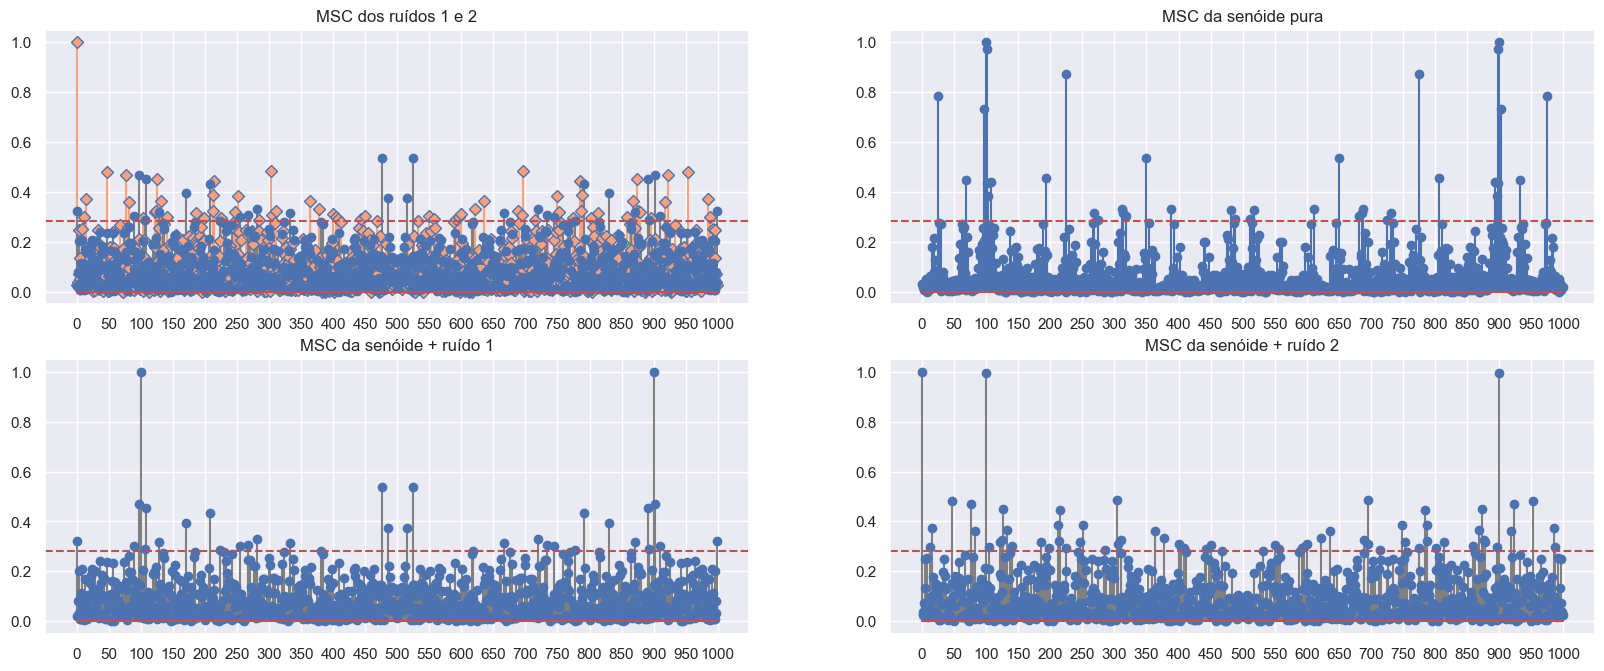

In [24]:
# Calcula senóide base e frequência para encontrar bins:
f0 = 100
fs = 1000
M = 10
tj = fs
N = M*tj

ruido1 = rd.randn(N)
ruido2 = 5*rd.randn(N)+10
sinal = senoide(amplitude=5, N=N, f0 = f0, fs=fs)
bin_f0 = round(len(sinal)*f0/fs)
limiar = vc_MSC(M=M, alpha=0.05)

# Calcula CSM:
[_,o1] = ord_MSC(sinal=ruido1, tamanhoJanela=tj, M=M)
[_,o2] =ord_MSC(sinal=ruido2, tamanhoJanela=tj, M=M)
[_,o3] =ord_MSC(sinal=sinal, tamanhoJanela=tj, M=M)
[_,o4] =ord_MSC(sinal=sinal+ruido1, tamanhoJanela=tj, M=M)
[_,o5] =ord_MSC(sinal=sinal+ruido2, tamanhoJanela=tj, M=M)

plt.subplot(221);
markerline, stemlines, baseline  = plt.stem(o2,linefmt='lightsalmon', markerfmt='D');
markerline.set_markerfacecolor('lightsalmon');
plt.stem(o1,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o2)+len(o2)/20,len(o2)/20));
plt.title('MSC dos ruídos 1 e 2');

plt.subplot(222);
plt.stem(o3);
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o3)+len(o3)/20,len(o3)/20));
plt.title('MSC da senóide pura');

plt.subplot(223);
plt.stem(o4,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o4)+len(o4)/20,len(o4)/20));
plt.title('MSC da senóide + ruído 1');

plt.subplot(224);
plt.stem(o5,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o5)+len(o5)/20,len(o5)/20));
plt.title('MSC da senóide + ruído 2');

# Algumas informações:
tamanhoSinal = len(o3)
bin_f0 = round(f0*tamanhoSinal/fs)
print('(Detecções no ruído 1) FP:',np.sum(np.where(o1>limiar))/N)
print('(Detecções no ruído 2) FP:',np.sum(np.where(o2>limiar))/N)
print('Detectou a senóide pura?', np.where(o3[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 1?', np.where(o4[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 2?', np.where(o5[bin_f0]>limiar,'Sim.','Não.'))

### 3.4.1 - Validação do valor crítico:

Simulando: 100%|██████████| 40/40 [00:14<00:00,  2.82it/s]


Pronto


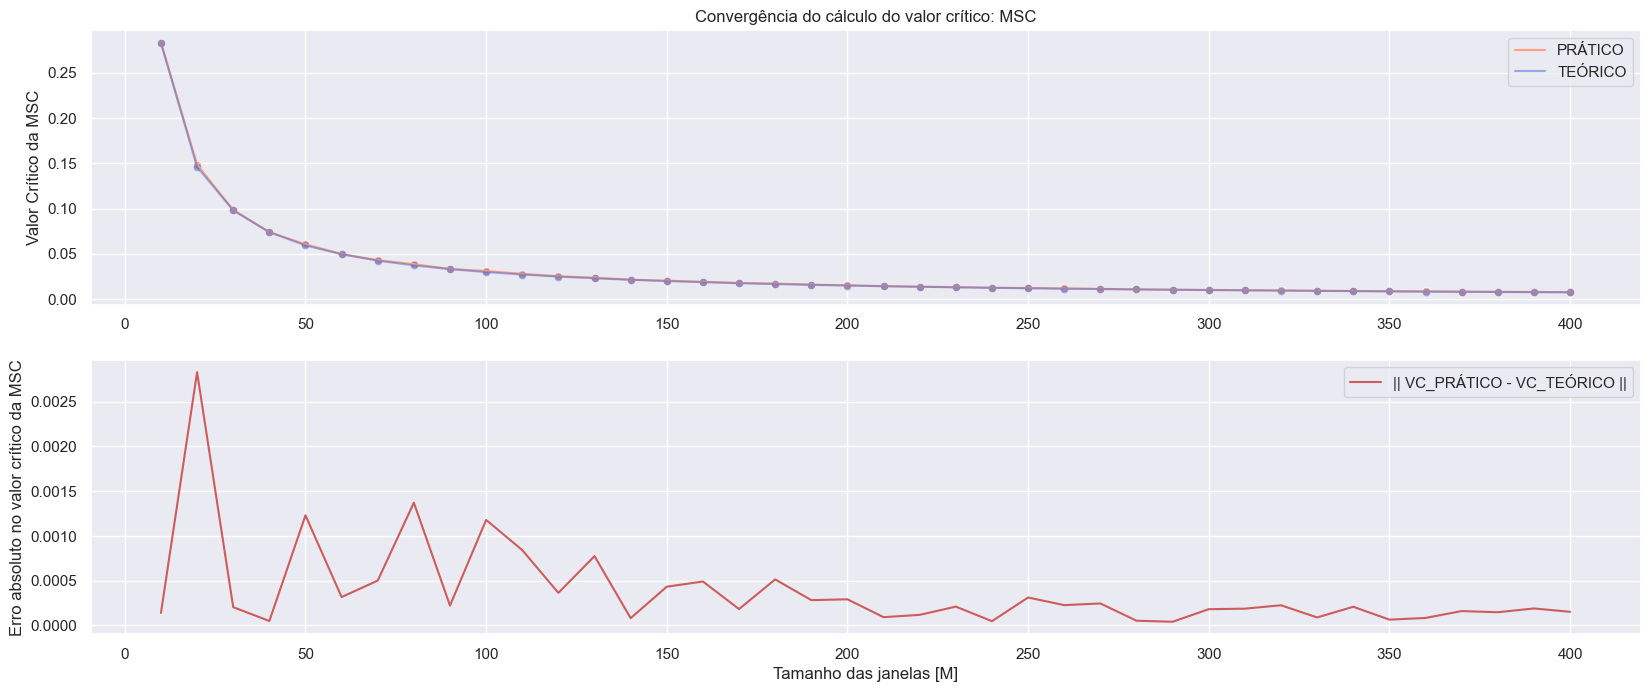

In [25]:
# MC:
## Parâmetros constantes:
nSim = round(1e3) # número de simulações
tj = 32     # tamanho da janela 
Mmin = 10; Mmax = 400; Mstep = 10; # Parâmetro livre da CSM
Ms = np.arange(Mmin,Mmax+Mstep,Mstep)   # tamanho qualquer 
bin = 7 # um bin qualquer
amplitudeRuido = 0 # média do ruído
energia_ruido = 1 # desvio padrão

## Variáveis:
vcp = np.zeros((len(Ms)))
vct = np.zeros((len(Ms)))
oo = np.zeros((nSim,tj))


for mm in tqdm(range(0,len(Ms)), desc='Simulando'):
    for ii in range(0,nSim):
        N = Ms[mm]*tj  # "duração" do sinal
        x = amplitudeRuido + energia_ruido*rd.randn(N,)
        [X,ORD] = ord_MSC(sinal=x, tamanhoJanela=tj, M=Ms[mm])
        oo[ii,:] = ORD
    
    vct[mm] = vc_MSC(Ms[mm])
    vcp[mm] = vc_pratico(oo) # alpha definido a 5%

print('Pronto')

plt.subplot(211)
p = sns.lineplot(x = Ms,y= vcp, color = 'lightsalmon') 
p = sns.lineplot(x = Ms,y = vct, color = 'royalblue',alpha = 0.5) 

plt.title('Convergência do cálculo do valor crítico: MSC');
plt.ylabel('Valor Crítico da MSC');


sns.scatterplot(x = Ms,y= vcp, color = 'lightsalmon'); 
sns.scatterplot(x = Ms,y = vct, color = 'royalblue',alpha = 0.5); 
plt.legend(['PRÁTICO','TEÓRICO']);
# plt.xlim([10, 400]);

plt.subplot(212)
p2 = sns.lineplot(x = Ms,y= abs(vcp-vct), color = 'indianred') 
plt.ylabel('Erro absoluto no valor crítico da MSC');
plt.legend(['|| VC_PRÁTICO - VC_TEÓRICO ||']);
plt.xlabel('Tamanho das janelas [M]');
# plt.xlim([10, 400]);

### 3.3.2 - Validação MSC: Single-shot MC

Simulando: 100%|██████████| 10000/10000 [00:12<00:00, 779.00it/s]


Probabilidade de detecção atingida: 94.07%
(PD esperada =  95.0%)
Detectou?  True


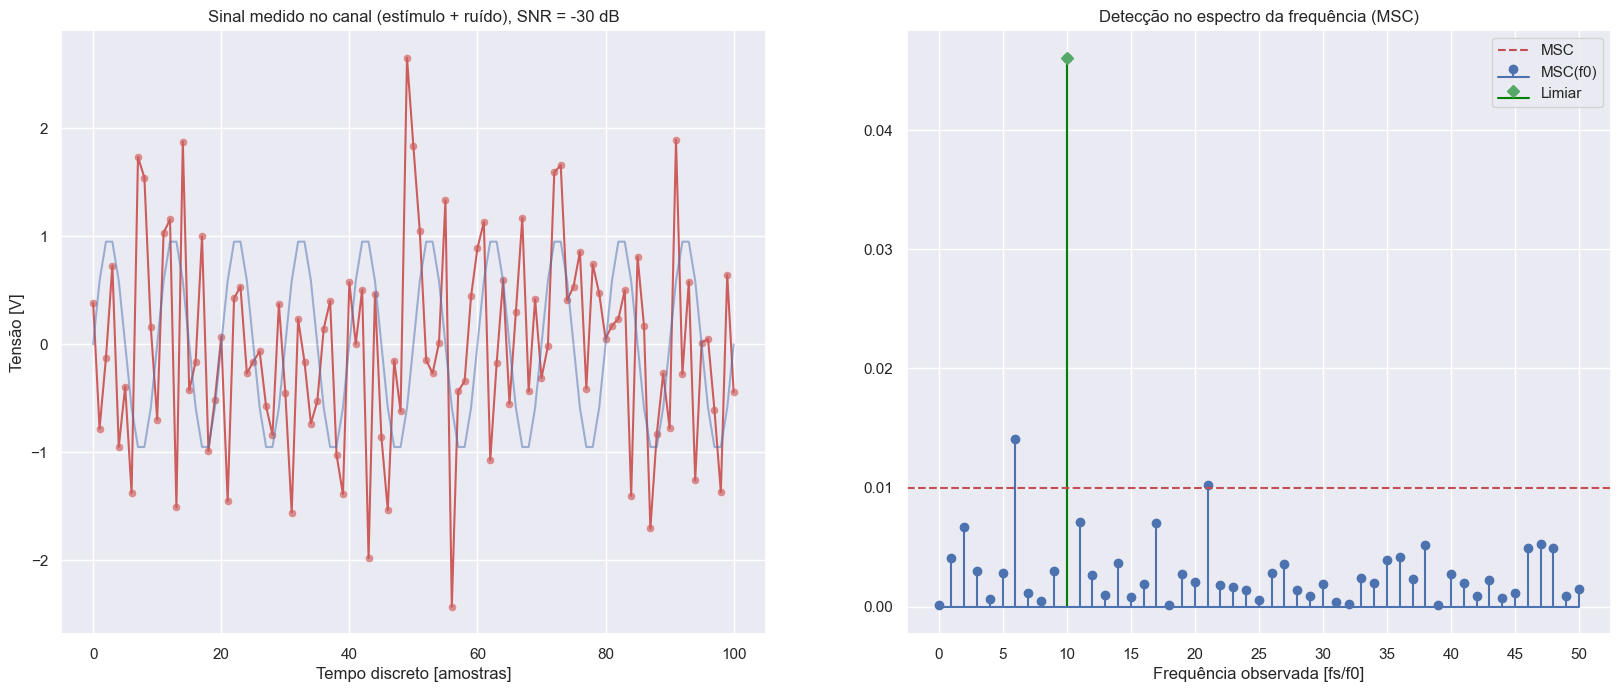

In [26]:
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)

# Calcula senóide base:
f0 = 100
fs = 1000
M = 300 # número de janelas até o teste
tj = 100 # 1 seg/jan
N = M*tj # num. de pontos na senóide
x = senoide(amplitude=1, N=N, f0 = f0, fs=fs)

amplitudeRuido = 0
energia_ruido = 1
SNRi = -30
A = 10**(SNRi/20)*(energia_ruido**2);
limiar = vc_MSC(M=M) # alpha = 5%
nd  = 0

for i in tqdm(range(0,nSim), desc = 'Simulando'):
    # Soma ruido aleatório novo à senóide inicial, em cada simulação:
    ruido = energia_ruido*rd.randn(N,) + amplitudeRuido
    sinal = A*x + ruido
    
    
    # Calcula MSC:
    [_, ORD]= ord_MSC(sinal = sinal, tamanhoJanela=tj, M= M)

    # Detecção?
    bin_f0 = round(len(ORD)*f0/fs)
    if  ORD[bin_f0] > limiar: nd +=1

print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')
print('(PD esperada = ',100*(1-alpha),'\b%)')

fig3 = plt.subplot(121);
sns.scatterplot(data = sinal[0:101], color='indianred', alpha = 0.65);
sns.lineplot(data = sinal[0:101], color='indianred');
sns.lineplot(data = x[0:101], color='b', alpha = 0.5);
titulo = 'Sinal medido no canal (estímulo + ruído), SNR = '+str(SNRi)+' dB'
plt.title(titulo);
plt.xlabel('Tempo discreto [amostras]');
plt.ylabel('Tensão [V]');

plt.subplot(122);
# print(fs/f0) # ORD está na frequencia observada (fl = fs/f0)
plt.stem(ORD[0:round(len(ORD)/2 +1)], linefmt= 'b', basefmt= 'b');
plt.stem(bin_f0, ORD[bin_f0], markerfmt='gD' ,linefmt= 'green',basefmt= 'green')
plt.axhline(y=limiar, color='r', linestyle = '--');
plt.title('Detecção no espectro da frequência (MSC)');
plt.xlabel('Frequência observada [fs/f0]');
plt.xticks(np.arange(0,round(len(ORD)/2 +len(ORD)/20), len(ORD)/20))
plt.legend(['MSC','MSC(f0)','Limiar'])
# plt.legend('CSM','Limiar');

print('Detectou? ', ORD[bin_f0] > limiar)
# Altere a amplitude do ruido para observar o efeito :)

### 3.3.3 - Validação MSC: Curva PD(SNR)

Simulando: 100%|██████████| 25/25 [05:43<00:00, 13.75s/it]


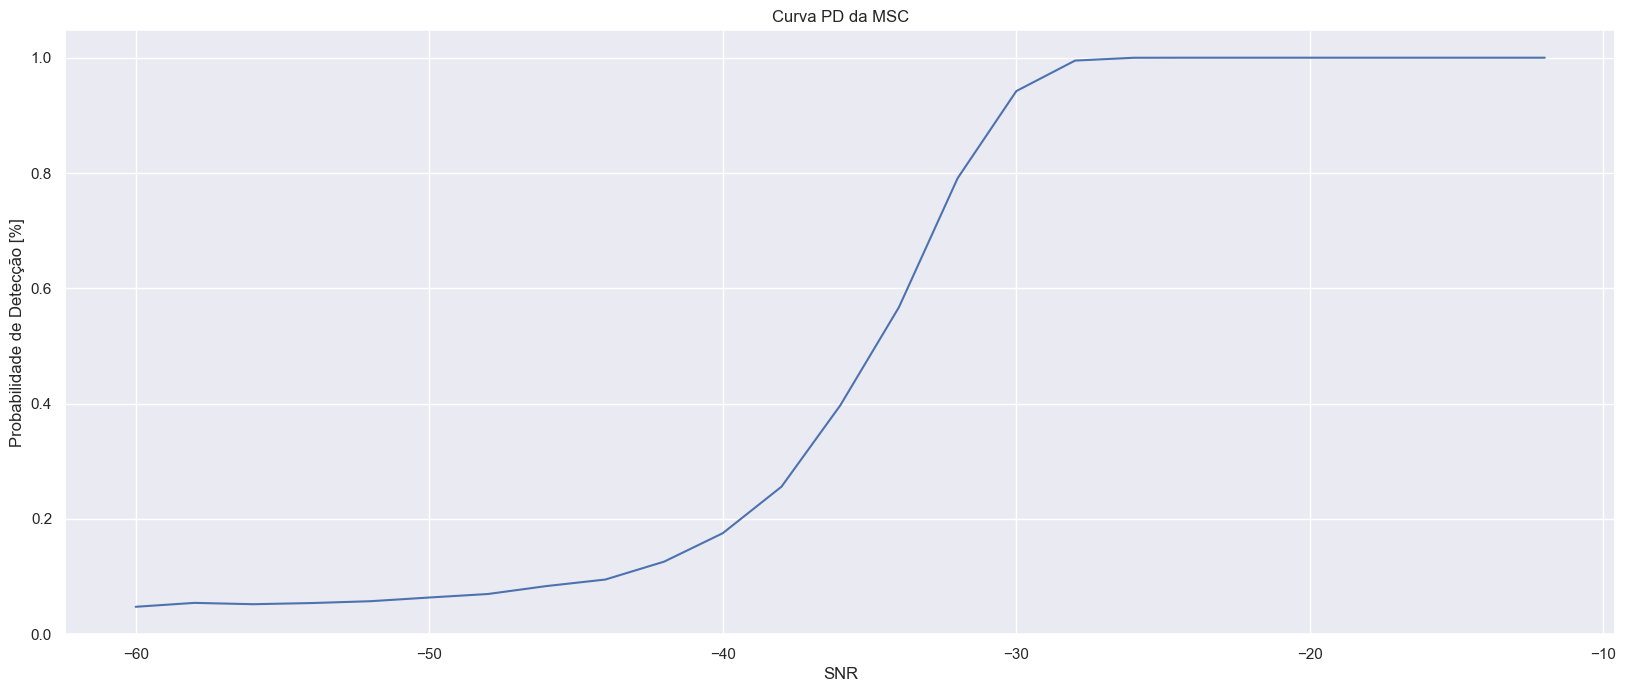

In [27]:
# Cerca de 6mins em média de simulação (24GB RAM, i5 8gen)
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)

# Calcula senóide base:
f0 = 100
fs = 1000
M = 300 # número de janelas até o teste
tj = 100 # 1 seg/jan
N = M*tj # num. de pontos na senóide
x = senoide(amplitude=1, N=N, f0 = f0, fs=fs)

amplitudeRuido = 0
energia_ruido = 1
limiar = vc_MSC(M=M) # alpha = 5%
listaSNRs = np.arange(-60,-10,2)
probDetecMSC = np.zeros((len(listaSNRs),1))
nd  = 0

for i in tqdm(range(0,len(listaSNRs)), desc = 'Simulando'):
    SNRi = listaSNRs[i]; nd = 0;
    A = 10**(SNRi/20)*(energia_ruido**2);
    
    for _ in range(0,nSim):
        # Soma ruido aleatório novo à senóide inicial, em cada simulação:
        ruido =  amplitudeRuido+ energia_ruido*rd.randn(N,)
        sinal = A*x + ruido
        
        # Calcula SFT na f0:
        [_, ORD]= ord_MSC(sinal = sinal, tamanhoJanela=tj, M= M)

        # Detecção?
        bin_f0 = round(len(ORD)*f0/fs)
        if  ORD[bin_f0] > limiar: nd +=1

    probDetecMSC[i] = nd/nSim
    # print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')

pDMSC = pd.DataFrame({'SNR': listaSNRs,'Probabilidade de Detecção [%]':probDetecMSC[:,0]})
sns.lineplot(data = pDMSC,x='SNR',y='Probabilidade de Detecção [%]');
plt.title('Curva PD da MSC');
pDMSC.to_csv('PD_MSC.csv')
# 406.3s